In [52]:
from hsflfm.analysis import (
    ResultManager,
    ResultPlotter,
    BulkAnalyzer,
    convert_to_percentile,
    get_random_percentile_index,
    sort_by_camera,
    get_percentiles
)

import os
from matplotlib import pyplot as plt
import torch
from hsflfm.util import load_dictionary, save_dictionary, play_video
from pathlib import Path
import numpy as np

In [ ]:
# get all the filenames
all_filenames = []
f = "temporary_result_storage"
folders = os.listdir(f)
for inner in folders:
    path = Path(f) / inner
    if path.is_dir():
        filenames = os.listdir(path)
        for filename in filenames:
            if filename[-4:] == "json":
                all_filenames.append(str(path / filename))

In [3]:
analyzer = BulkAnalyzer(all_filenames)

In [ ]:
reload = False
if reload:
    analyzer.load_results()
    save_dictionary(analyzer.all_results, "temp_loaded_results.json")
else:

    analyzer.all_results = load_dictionary("temp_loaded_results.json")

    for key, value in analyzer.all_results.items():

        if key == "specimen_number":

            analyzer.all_results[key] = np.asarray(value)

            continue

        analyzer.all_results[key] = torch.asarray(value)

In [ ]:
# look at all results on the mesh

p = analyzer.all_results["mesh_points"]

# jitter the points

jitter = 100

rand = (torch.rand(p.shape) - 0.5) * jitter

p = p + rand

v = analyzer.all_results["normalized_displacement"][:, 2]

v = convert_to_percentile(v)

ResultPlotter.plot_mesh_with_points(
    points=p,
    opacity=0.1,
    point_values=v,
    points_on_surface=True,
    marker_dict={"size": 2, "colorscale": "Turbo"},
)

C:\Users\clare\AppData\Local\Temp\ipykernel_80680\3583210198.py:17: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.



Text(0.5, 1.0, 'Flow error in region around strike')

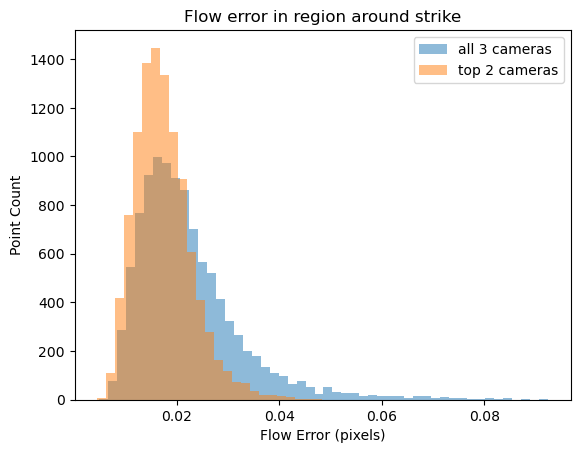

In [6]:
# histogram flow differences
key = "average_flow_error"
all_flow = torch.mean(torch.abs(analyzer.all_results[key]), axis=1)
all_flow, _ = torch.sort(all_flow)

# cut-off at some percentile
cutoff = 0.995
cutoff_index = int(len(all_flow) * cutoff)

bins = plt.hist(all_flow[:cutoff_index], bins=50, alpha=0.5, label="all 3 cameras")
width = bins[1][1] - bins[1][0]

# add in the top two
flow = analyzer.get_top_values(key)
flow, _ = torch.sort(torch.mean(torch.abs(flow), axis=1))
flow = flow[:cutoff_index]
bins = np.arange(min(flow), max(flow) + width, width)
_ = plt.hist(flow, bins=bins, alpha=0.5, label="top 2 cameras")

plt.legend()
plt.ylabel("Point Count")
plt.xlabel("Flow Error (pixels)")
plt.title("Flow error in region around strike")

C:\Users\clare\AppData\Local\Temp\ipykernel_80680\696678256.py:17: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.



Text(0.5, 1.0, 'Huber Loss in region around strike')

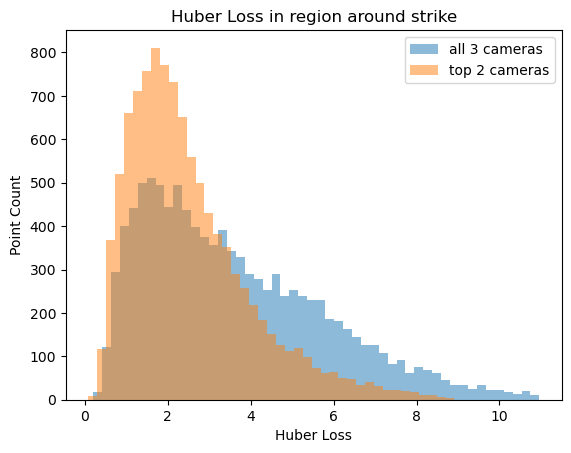

In [ ]:
# histogram flow differences
key = "average_huber_loss"
all_flow = torch.mean(torch.abs(analyzer.all_results[key]), axis=1)
all_flow, _ = torch.sort(all_flow)

# cut-off at some percentile
cutoff = 0.995
cutoff_index = int(len(all_flow) * cutoff)

bins = plt.hist(all_flow[:cutoff_index], bins=50, alpha=0.5, label="all 3 cameras")
width = bins[1][1] - bins[1][0]

# add in the top two
flow = analyzer.get_top_values(key)
flow, _ = torch.sort(torch.mean(torch.abs(flow), axis=1))
flow = flow[:cutoff_index]
bins = np.arange(min(flow), max(flow) + width, width)
_ = plt.hist(flow, bins=bins, alpha=0.5, label="top 2 cameras")

plt.legend()
plt.ylabel("Point Count")
plt.xlabel("Huber Loss")
plt.title("Huber Loss in region around strike")

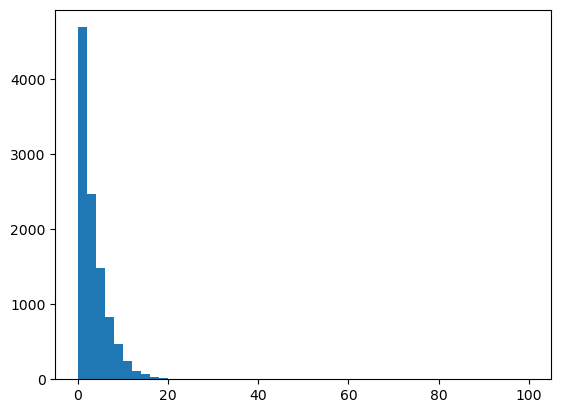

In [ ]:
# percentile differences between huber and flow in top 2 cameras
huber_percentiles = analyzer.get_percentile("average_huber_loss", num_cams=2)
flow_percentiles = analyzer.get_percentile("average_flow_error", num_cams=2)

diffs = torch.abs(huber_percentiles - flow_percentiles)

_ = plt.hist(diffs, bins=50)

In [79]:
# look at some points with bad flow
array = torch.mean(analyzer.get_top_values("average_flow_error", num_cams=2), axis=1)
index = get_random_percentile_index(array.numpy(), 90, 98)

specimen_number = analyzer.all_results["specimen_number"][index]
point_number = int(analyzer.all_results["point_number"][index])
strike_number = int(analyzer.all_results["strike_number"][index])

print(specimen_number, "point", point_number, "strike", strike_number)
print("flow error: {:.5f} pixels".format(array[index]))
print("percentile: {:.0f}%".format(100 * get_percentiles(array.numpy(), float(array[index]))))

20220427_OB_4 point 11 strike 3
flow error: 0.03017 pixels
percentile: 97%


In [ ]:
# specimen_number = "20240507_OB_2"
# point_number = 31
# strike_number = 10

In [86]:
filename = (
    f"temporary_result_storage/{specimen_number}/strike_{strike_number}_results.json"
)
assert os.path.exists(filename)

result_info = load_dictionary(filename)
plotter = ResultPlotter(result_info)

plotter.result_info["removed_points"]

[16, 17, 21, 18, 10, 20, 22]

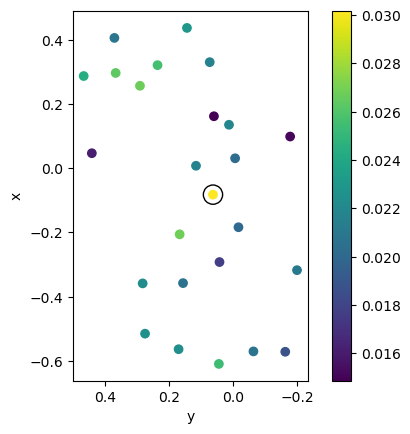

In [81]:
flow_diffs = plotter.result_manager.flow_diff_around_strike()
_, sorted = sort_by_camera(flow_diffs[:, :, None], treat_individually=False)
values = sorted.squeeze()[:, :2]
values = torch.mean(values, axis=1)
_ = plotter.scatter_values(values, highlight_point=point_number)

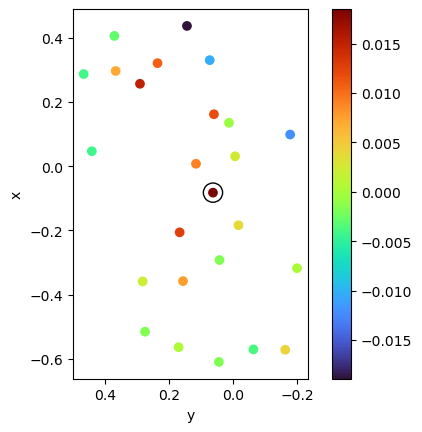

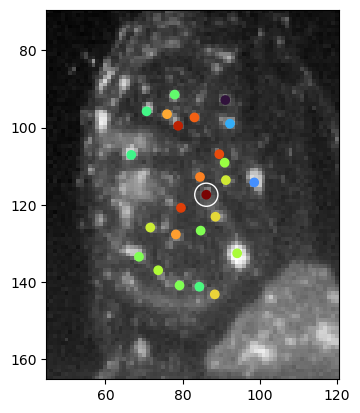

In [82]:
plotter.scatter_peak_disp(highlight_point=point_number, cmap="turbo")
plotter.scatter_peak_disp(highlight_point=point_number, cmap="turbo", with_image=True)

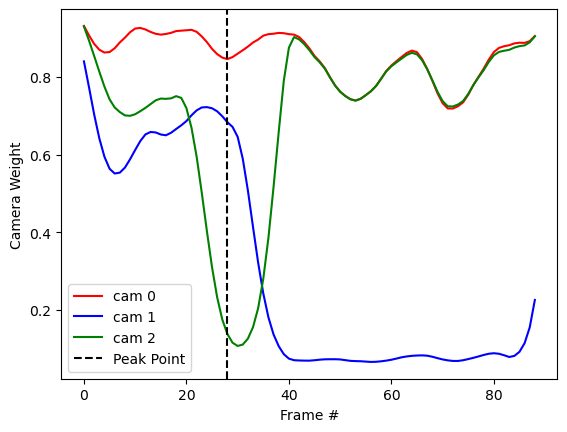

In [83]:
_ = plotter.plot_camera_weight(point_number)

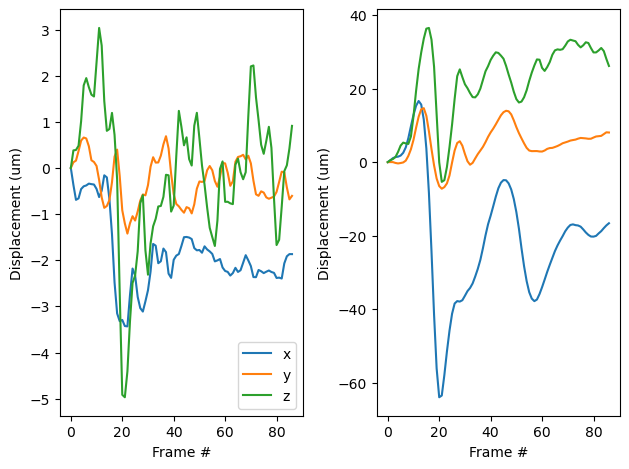

In [76]:
_ = plotter.plot_displacement(point_number)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

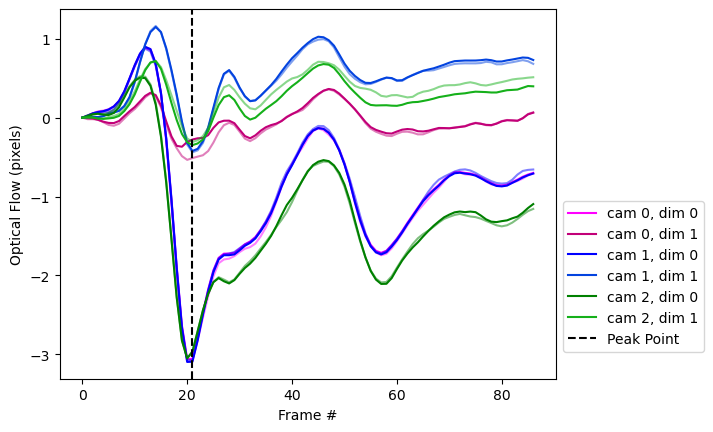

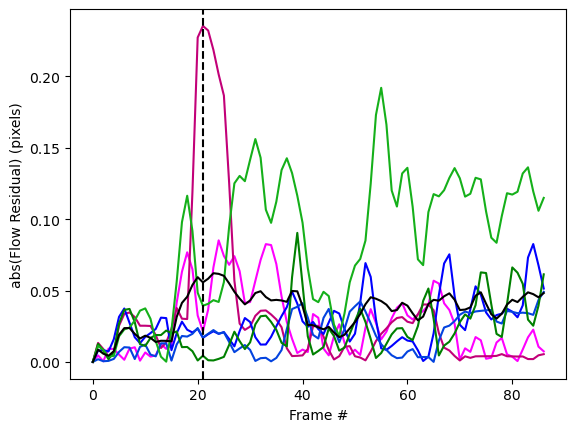

In [77]:
plotter.show_flow_differences(point_number)

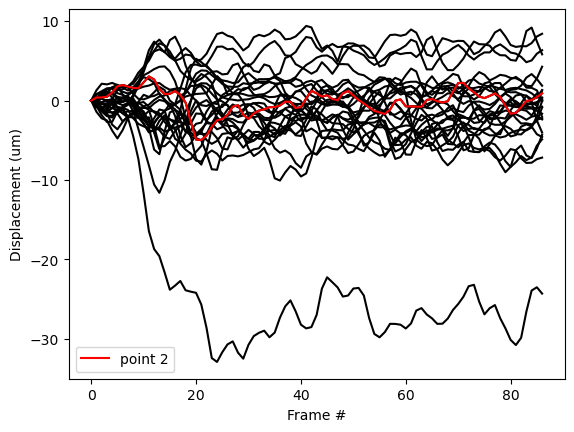

In [78]:
_ = plotter.plot_all_displacement(highlight_point=point_number)

In [67]:
vid = plotter.make_point_track_video(highlight_point=point_number)

108it [00:04, 22.15it/s]


<Figure size 640x480 with 0 Axes>

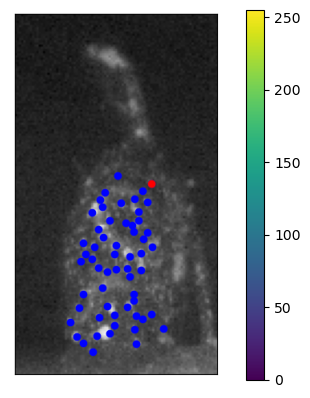

In [68]:
play_video(vid)

In [69]:
vid = plotter.get_arrow_video()

108it [00:27,  3.92it/s]


<Figure size 640x480 with 0 Axes>

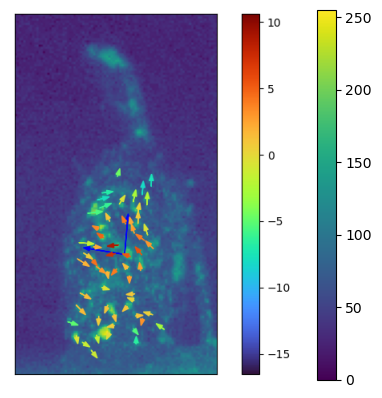

In [70]:
play_video(vid)

In [ ]:
# look into more:
# 20240507_OB_2 point 31 strike 10
# 20240502_OB_6 29

# good examples
# 20240418_OB_1 barely any movement but clear pattern

In [ ]:
# suggested threshold for being used in global movement calculation:
# 0.025 average error with top two cameras
# in region surrounding peak 

# ummmm and I want to adjust how I'm handling transfering points between images
# maybe makes sense not to drop points until the analysis is done ?
# I can just keep track of which points were used to do the transform between strikes
# and maybe save the residuals of that to get a sense of whether 
# the points are really pointing to the same spot 

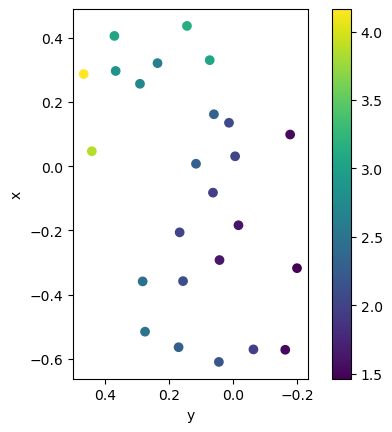

In [109]:
cam = 0 
pn = np.asarray(result_info["point_numbers"], dtype=int)
p1 = np.asarray(result_info["strike1_match_points"][cam])[pn, :2]
p2 = np.asarray(result_info["match_points"][cam])
diff = np.linalg.norm(p1 - p2, axis=1)

_ = plotter.scatter_values(diff)